<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting VCB  stock price with Neural Networks (DNN only)



## Imports

You will use the same imports as before with the addition of the [csv](https://docs.python.org/3/library/csv.html) module. You will need this to parse the CSV file containing the dataset.

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time


## Utilities

You will only have the `plot_series()` dataset here because you no longer need the synthetic data generation functions.

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

You can now download the dataset and inspect the contents. The link in class is from Laurence's repo but we also hosted it in the link below.

In [3]:
import pandas as pd

In [4]:
data=pd.read_csv('excel_vcb.csv')

In [5]:
data.head

<bound method NDFrame.head of       time <Ticker>  <DTYYYYMMDD>   <Open>   <High>    <Low>  <Close>  \
0        0      VCB      20090630  16.2426  16.2426  16.2426  16.2426   
1        1      VCB      20090701  16.2426  17.0547  16.1072  16.3779   
2        2      VCB      20090702  16.3779  16.3779  15.5658  15.7011   
3        3      VCB      20090703  15.7011  15.7011  15.1597  15.1597   
4        4      VCB      20090706  15.1597  15.8365  15.1597  15.8365   
...    ...      ...           ...      ...      ...      ...      ...   
3459  3459      VCB      20230515  92.8000  93.0000  91.2000  91.7000   
3460  3460      VCB      20230516  91.7000  93.1000  91.3000  92.6000   
3461  3461      VCB      20230517  92.6000  93.0000  92.3000  92.8000   
3462  3462      VCB      20230518  92.8000  96.0000  92.2000  95.0000   
3463  3463      VCB      20230519  95.0000  95.0000  92.6000  93.0000   

      <Volume>  
0       294070  
1      6248390  
2      1515670  
3       899720  
4      1

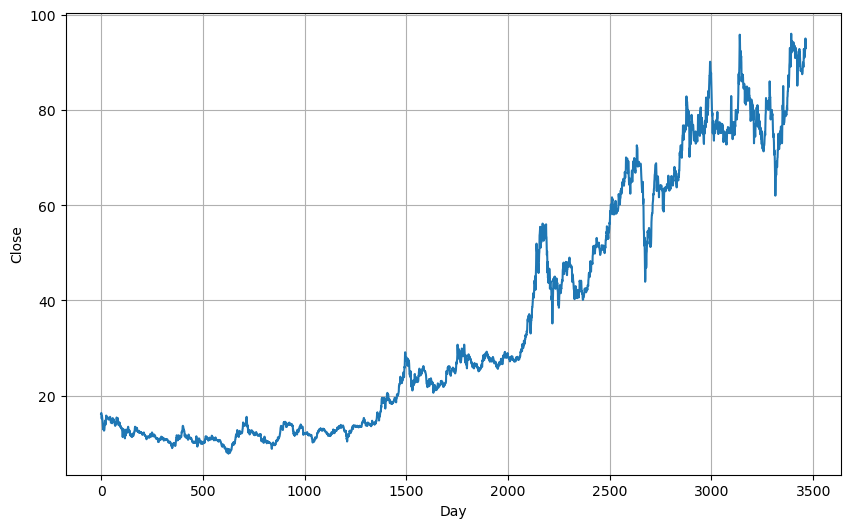

In [6]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('excel_vcb.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[6]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='Close')

Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the day number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Stock Price

## Split the Dataset

Next, you will split the dataset into training and validation sets. There are 3464 points in the dataset and you will use the first 3000 for training.

In [7]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

You can then prepare the dataset windows as before. The window size is set to 30 points (equal to 2.5 years) but feel free to change later on if you want to experiment.

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [9]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

The model will be 3-layer dense network as shown below.

In [10]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

You can pick a learning rate by running the same learning rate scheduler code from previous labs.

In [11]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 2s 15ms/step - loss: 93.3991 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 0s 4ms/step - loss: 92.6028 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 0s 4ms/step - loss: 91.7051 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 0s 4ms/step - loss: 90.7018 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 0s 4ms/step - loss: 89.5794 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 0s 4ms/step - loss: 88.3256 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 0s 4ms/step - loss: 86.9251 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 0s 4ms/step - loss: 85.3608 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 0s 3ms/step - loss: 83.6159 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 0s 4ms/step - loss: 81.6669 - lr: 2.8184e-08
Epoch 11/100
93/93

93/93 [==============================] - 1s 4ms/step - loss: 0.7723 - lr: 1.4125e-04
Epoch 85/100
93/93 [==============================] - 0s 4ms/step - loss: 0.8073 - lr: 1.5849e-04
Epoch 86/100
93/93 [==============================] - 0s 4ms/step - loss: 0.9015 - lr: 1.7783e-04
Epoch 87/100
93/93 [==============================] - 0s 4ms/step - loss: 1.3459 - lr: 1.9953e-04
Epoch 88/100
93/93 [==============================] - 0s 4ms/step - loss: 0.8423 - lr: 2.2387e-04
Epoch 89/100
93/93 [==============================] - 0s 3ms/step - loss: 1.0464 - lr: 2.5119e-04
Epoch 90/100
93/93 [==============================] - 1s 4ms/step - loss: 0.8637 - lr: 2.8184e-04
Epoch 91/100
93/93 [==============================] - 1s 4ms/step - loss: 1.0337 - lr: 3.1623e-04
Epoch 92/100
93/93 [==============================] - 1s 5ms/step - loss: 1.6847 - lr: 3.5481e-04
Epoch 93/100
93/93 [==============================] - 1s 4ms/step - loss: 3.3759 - lr: 3.9811e-04
Epoch 94/100
93/93 [=============

(1e-08, 0.001, 0.0, 100.0)

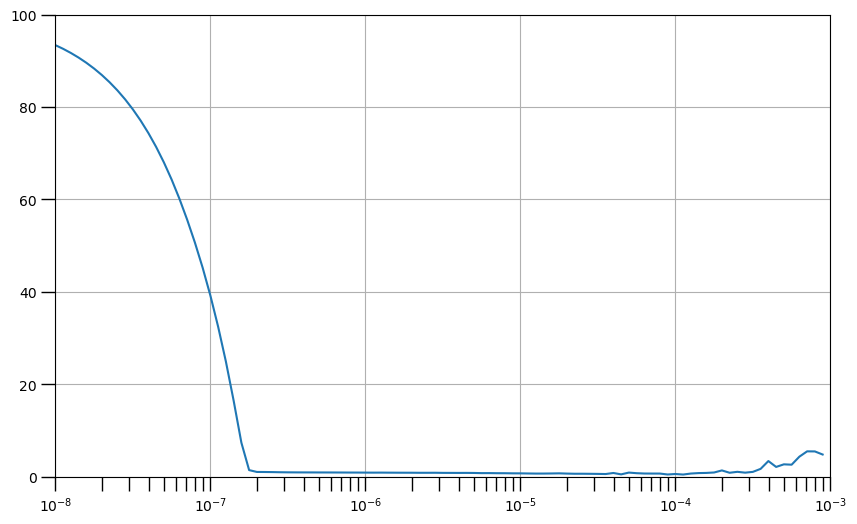

In [12]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Once you've picked a learning rate, you can rebuild the model and start training.

In [13]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [19]:
import datetime
start_time = time.time()
# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Kết thúc tính thời gian huấn luyện
train_time_cls = time.time() - start_time
print(f'Thời gian huấn luyện mô hình DNN: {train_time_cls:.4f} giây')

Epoch 1/100
93/93 [==============================] - 1s 4ms/step - loss: 37.5173 - mse: 2032.8024
Epoch 2/100
93/93 [==============================] - 1s 4ms/step - loss: 19.6551 - mse: 562.2554
Epoch 3/100
93/93 [==============================] - 1s 4ms/step - loss: 5.8200 - mse: 56.6753
Epoch 4/100
93/93 [==============================] - 1s 4ms/step - loss: 0.8048 - mse: 3.4140
Epoch 5/100
93/93 [==============================] - 1s 4ms/step - loss: 0.7476 - mse: 3.1508
Epoch 6/100
93/93 [==============================] - 1s 4ms/step - loss: 0.6901 - mse: 2.8464
Epoch 7/100
93/93 [==============================] - 1s 4ms/step - loss: 0.6533 - mse: 2.6642
Epoch 8/100
93/93 [==============================] - 1s 4ms/step - loss: 0.6335 - mse: 2.5503
Epoch 9/100
93/93 [==============================] - 1s 4ms/step - loss: 0.6154 - mse: 2.4300
Epoch 10/100
93/93 [==============================] - 1s 4ms/step - loss: 0.5849 - mse: 2.2733
Epoch 11/100
93/93 [==============================]

93/93 [==============================] - 0s 4ms/step - loss: 0.4418 - mse: 1.5470
Epoch 88/100
93/93 [==============================] - 0s 4ms/step - loss: 0.4418 - mse: 1.5476
Epoch 89/100
93/93 [==============================] - 0s 4ms/step - loss: 0.4392 - mse: 1.5378
Epoch 90/100
93/93 [==============================] - 0s 4ms/step - loss: 0.4358 - mse: 1.5215
Epoch 91/100
93/93 [==============================] - 0s 4ms/step - loss: 0.4326 - mse: 1.5053
Epoch 92/100
93/93 [==============================] - 0s 4ms/step - loss: 0.4320 - mse: 1.4985
Epoch 93/100
93/93 [==============================] - 0s 3ms/step - loss: 0.4290 - mse: 1.4851
Epoch 94/100
93/93 [==============================] - 1s 4ms/step - loss: 0.4257 - mse: 1.4776
Epoch 95/100
93/93 [==============================] - 1s 5ms/step - loss: 0.4235 - mse: 1.4660
Epoch 96/100
93/93 [==============================] - 1s 4ms/step - loss: 0.4228 - mse: 1.4613
Epoch 97/100
93/93 [==============================] - 1s 4ms/st

## Model Prediction

Now see if the model generates good results. If you used the default parameters of this notebook, you should see the predictions follow the shape of the ground truth with an MSE of around 3. 

In [20]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

15/15 [==============================] - 0s 7ms/step
Thời gian dự đoán mô hình DNN: 0.2849 giây


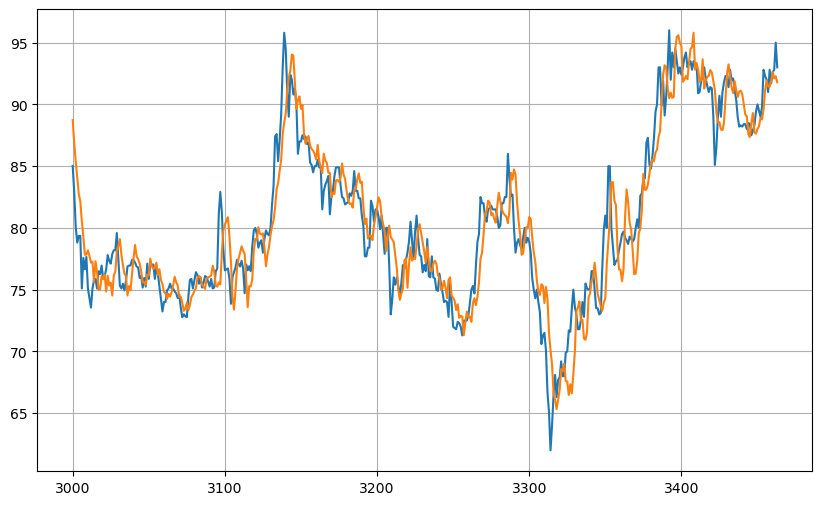

[88.73056  86.86544  85.36836  84.00743  82.73999  82.16208  80.52369
 79.28254  77.81889  77.85102  78.17981  77.743835 77.197136 77.27954
 75.62907  77.306915 76.42539  75.00441  75.0204   76.08976  75.850876
 76.23397  74.85256  76.12179  75.33975  75.56816  74.52753  76.15188
 76.446785 78.18357  78.51522  79.09169  77.83518  76.99478  76.28992
 76.1189   74.52893  75.29289  74.953064 76.23896  77.60223  78.62147
 77.69588  77.47271  77.113945 76.47642  75.576256 75.64413  75.3952
 76.21969  76.14139  77.51663  76.913475 76.693184 76.75639  77.18305
 76.1913   76.65448  75.77614  75.43971  74.80179  74.738266 74.2508
 74.65787  74.442    74.77556  75.366974 76.04638  75.60252  75.35459
 74.42256  74.43986  73.93391  73.28917  73.4596   73.96501  73.341965
 73.74526  74.41177  74.60353  74.906395 75.128044 75.972565 76.11897
 75.9328   75.434944 75.23895  75.06603  75.92339  75.97196  76.05751
 76.14678  76.9403   76.47045  75.3221   75.24509  75.58473  75.42572
 77.94975  79.77913 

In [21]:
# Bắt đầu tính thời gian dự đoán
start_time = time.time()
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()
# Kết thúc tính thời gian huấn luyện
train_time_cls = time.time() - start_time
print(f'Thời gian dự đoán mô hình DNN: {train_time_cls:.4f} giây')
# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

In [22]:
# Compute the MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
m = tf.keras.metrics.Accuracy()
m.result()

5.8017473


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [23]:
# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

MSE: 5.8017473
Mean Error Percent: 0.023012027984756708
Accuracy: 0.9769879720152433


## Wrap Up

In this lab, you built a relatively simple DNN to forecast VCB stock price for a given day. We encourage you to tweak the parameters or train longer and see the best results you can get. 

1/1 [==============================] - 0s 57ms/step
Thời gian dự báo 10 ngày tiếp theo: 0.7955 giây
Dự báo cho 10 ngày tiếp theo: [array(93.18504, dtype=float32), array(93.17904, dtype=float32), array(94.071495, dtype=float32), array(93.93919, dtype=float32), array(94.0343, dtype=float32), array(93.792435, dtype=float32), array(94.00965, dtype=float32), array(93.11915, dtype=float32), array(94.18372, dtype=float32), array(93.86094, dtype=float32)]


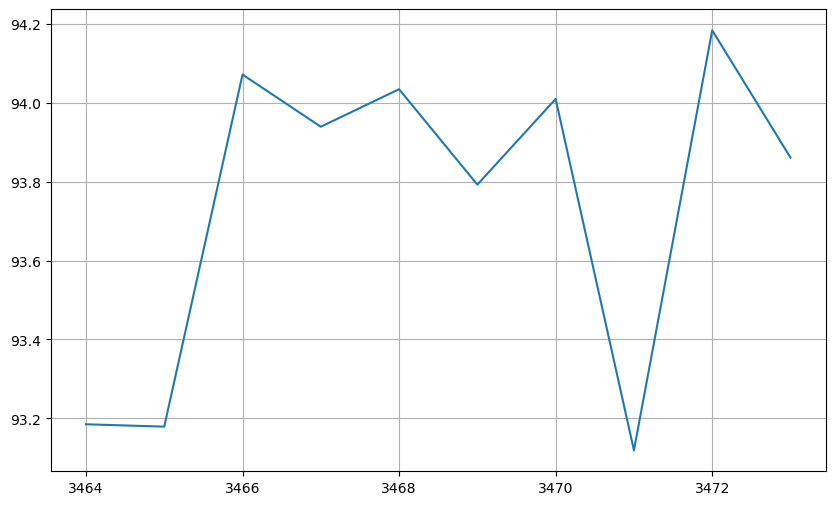

In [24]:
# Bắt đầu tính thời gian dự đoán
start_time = time.time()

# Số ngày cần dự báo
forecast_horizon = 10

# Lấy các giá trị cuối cùng làm đầu vào cho dự báo
input_series = series[-window_size:]  # Lấy dữ liệu cuối với kích thước window_size
predictions = []

# Dự báo từng ngày cho horizon
for _ in range(forecast_horizon):
    # Tạo dự báo cho bước tiếp theo
    forecast = model_forecast(model, input_series, window_size, batch_size)
    next_day_prediction = forecast[-1].squeeze()  # Lấy giá trị dự báo mới nhất
    
    # Thêm vào danh sách dự báo
    predictions.append(next_day_prediction)
    
    # Cập nhật input_series cho lần dự báo tiếp theo
    input_series = np.append(input_series[1:], next_day_prediction)

# Kết thúc tính thời gian dự đoán
train_time_cls = time.time() - start_time
print(f'Thời gian dự báo 10 ngày tiếp theo: {train_time_cls:.4f} giây')

# Hiển thị kết quả dự báo 10 ngày
print("Dự báo cho 10 ngày tiếp theo:", predictions)

# Plot kết quả nếu muốn
plot_series(range(len(series), len(series) + forecast_horizon), predictions)
